# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Step 0: Load The Data

In [1]:
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.  
**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
import numpy as np

n_train = np.shape(x_train)[0]
n_test = np.shape(x_test)[0]
image_shape = np.shape(x_train)[1:3]
n_classes = np.max(x_train) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 256


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

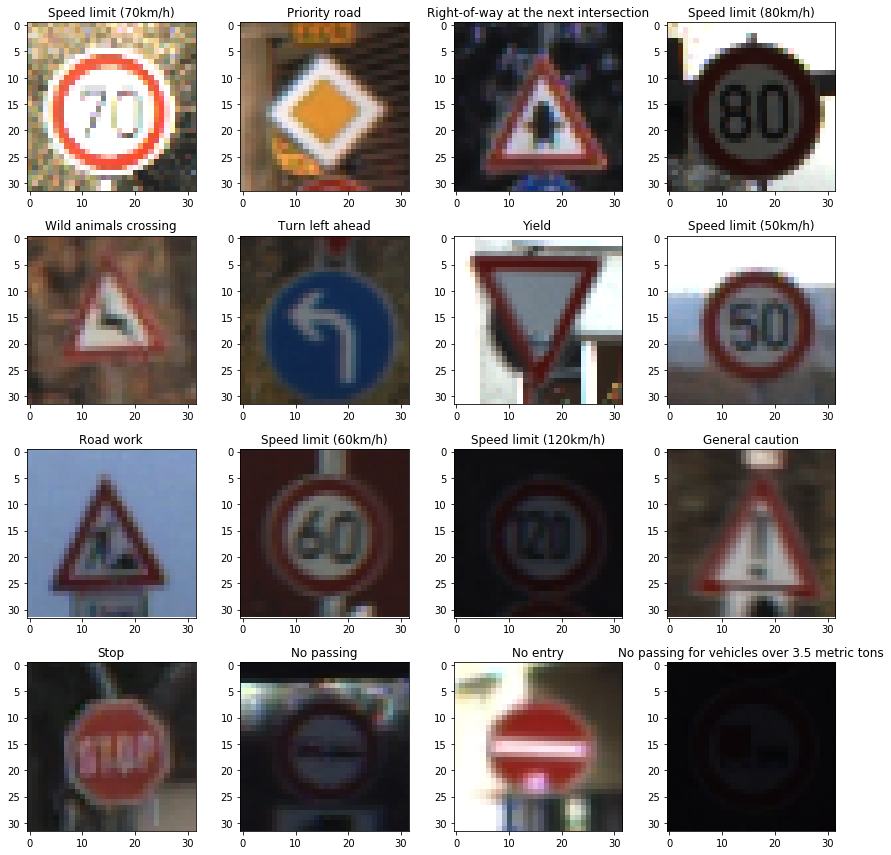

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

signnames = pd.read_csv('signnames.csv')

'''creat a label set as dictionary, extract elements from signnames and mapping Signname to ClassId in label_set'''
label_set = dict()
for ele in signnames.iterrows():  # iterate every row
    r = ele[1]
    ClassId = r['ClassId']
    SignName = r['SignName']
    label_set[ClassId] = SignName
    
'''random pickup feature from train set, output features and labels by figure = n_rows * n_cols'''
n_rows = 4
n_cols = 4
n_samples = n_rows * n_cols
sample = np.random.randint(0, n_train, n_samples)
sample_images = x_train[sample]
sample_labels = [label_set[s] for s in  y_train[sample]]

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_rows, 3*n_cols)) # it is hard to read the title if number<3
axes = axes.ravel()
fig.tight_layout()
for axis, image, label in zip(axes, sample_images, sample_labels):
    axis.imshow(image)
    axis.set_title(label)

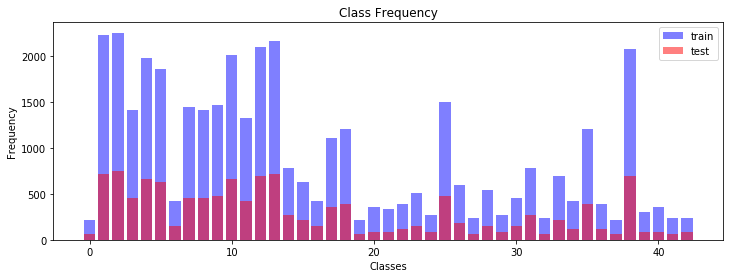

In [4]:
'''count train data and test data'''
unique1, counts1 = np.unique(y_train, return_counts=True)
dict_classes_count1 = dict(zip(unique1, counts1))
unique2, counts2 = np.unique(y_test, return_counts=True)
dict_classes_count2 = dict(zip(unique2, counts2))

'''combine bar of train and bar of test into figure'''
plt.figure(figsize=(12, 4))
plt.bar(range(len(dict_classes_count1)), dict_classes_count1.values(), width=0.8, label="train", color="b", alpha=0.5)
plt.bar(range(len(dict_classes_count2)), dict_classes_count2.values(), width=0.8, label="test", color="r", alpha=0.5)
plt.legend(loc="best")
plt.title('Class Frequency')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

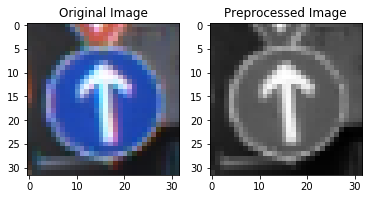

In [5]:
### Question 1 #####################
'''load the data already, just need to remember x=feature=image, y=label=title'''
# function set for grayscale, normalize, float
import cv2
def grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0] for img in images])

def normalize(images):
    a = 0.01
    b = 0.99
    color_min = 0.0     # Implement Min-Max scaling for image data
    color_max = 255.0
    return a + ( ( (images - color_min) * (b - a) )/(color_max - color_min))

def float32(images):
    return images.astype(np.float32)

def preprocess(images):
    gray = grayscale(images)
    norm = normalize(gray)
    return float32(norm)

from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

x_train_preprocess = preprocess(x_train)
x_test_preprocess = preprocess(x_test)

index = np.random.randint(0, len(x_train_preprocess))
plt.subplot(1,2,1) # n_rows, n_cols, n_order
plt.imshow(x_train[index])
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Preprocessed Image")
plt.imshow(x_train_preprocess[index], cmap='gray')
plt.show()

In [6]:
### Question 2 #####################
# first step: randomly rotate images between -15 to 15
def rotate_random(img):
    rotation = np.random.randint(-15, 15)
    r_m = cv2.getRotationMatrix2D((16,16),rotation,1)
    r_i = cv2.warpAffine(img,r_m,(32,32))
    return r_i

# second step: transform images
def perspective_transform(img):
    low_rand = np.random.randint(0, 5)
    high_rand = np.random.randint(27, 32)
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[high_rand,low_rand],[low_rand,32],[32,high_rand]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    return cv2.warpPerspective(img,M,(32,32))

from scipy import average
avg = average(counts1)  # in step 1 section, we counting train label as counts1
new_x_train = x_train_preprocess # dumplicate a new dataset from preprocessed dataset for append function
new_y_train = y_train

# third step: random rotate all images and append into new dataset
for itr in range(0, 3):
    for key in dict_classes_count1:  # also in step 1 section
        if dict_classes_count1[key] <= avg:
            rot_x = []
            rot_y = []
            for t in range(np.shape(new_x_train)[0]): # read next comment
                if new_y_train[t] == key:
                    rot_x.append(rotate_random(new_x_train[key]))  # can use x_train_preprocess instead of new_x_train
                    rot_y.append(key)                              # read comments on fourth step for reason
            if len(rot_y) > 0:
                new_x_train = np.append(new_x_train, rot_x, axis=0)
                new_y_train = np.append(new_y_train, rot_y, axis=0)

# fourth step: Perspective transform all images and append into new dataset
trans_x = []
trans_y = []
counter = np.shape(new_x_train)[0] # read next two comments
for u in range(counter):
    trans_x.append(perspective_transform(new_x_train[u])) # new_x_train includes rotated data in this loop
    trans_y.append(new_y_train[u])  # use x_train_preprocess and y_train if don't want to transform rotated data

new_x_train = np.append(new_x_train, trans_x, axis=0)
new_y_train = np.append(new_y_train, trans_y, axis=0)

# verify if generated additional data
print(np.shape(x_train_preprocess))
print(np.shape(new_x_train))
print(np.shape(new_y_train))

(39209, 32, 32)
(225404, 32, 32)
(225404,)


In [7]:
### Question 2 #####################
# Split validation dataset off from training dataset
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(new_x_train, new_y_train, test_size=0.20, random_state=42)

print("Original x_train:",len(new_x_train))
print("Splited x_train:",len(x_train))
print("Splited X_validation:",len(x_validation))

Original x_train: 225404
Splited x_train: 180323
Splited X_validation: 45081


In [8]:
### save new train data, but we don't need to use this step in this project ###
#import os
#pickle_file = 'traffic-signs-data/new_train.p'
#if not os.path.isfile(pickle_file):
#    try:
#        with open(pickle_file, 'wb') as pfile:
#            pickle.dump({'train_dataset': x_train,'train_labels': y_train,
#                    'valid_dataset': x_valid,'valid_labels': y_valid,
#                    'test_dataset': x_test,'test_labels': y_test,},pfile, pickle.HIGHEST_PROTOCOL)
#    except Exception as e:
#        print('Unable to save data to', pickle_file, ':', e)
#        raise
#print('Data Saved')

In [28]:
### Question 3 #####################
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):  # create some wrappers for simplicity, conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):  # pooling
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

def conv_net(x, weights, biases, dropout):  # create model
    # layer 1
    conv1 = conv2d(x, weights['w1'], biases['b1']) # 32x32x1 to 28x28x6
    conv1 = maxpool2d(conv1, k=2)                  # 28x28x6 to 14x14x6

    # layer 2
    conv2 = conv2d(conv1, weights['w2'], biases['b2'])   # 14x14x6 to 10x10x16
    conv2 = maxpool2d(conv2, k=2)                        # 10x10x16 to 5x5x16
    
    # layer 3
    conv3 = conv2d(conv2, weights['w3'], biases['b3'])   # 5x5x6 to 1x1x400, no pooling in here since 1x1 already                       

    # fully connected layer
    fc = flatten(conv3)     # flatten 1x1x400 to 400 layers
    fc = tf.add(tf.matmul(fc, weights['wd']), biases['bd'])     # output to fit fully connected layer, 400 to 120
    fc = tf.nn.relu(fc)           # relu activation
    fc = tf.nn.dropout(fc, dropout) # apply dropout

    # output Layer - class prediction, 120 to 43, n_classes=43
    out = tf.add(tf.matmul(fc, weights['out']), biases['out'])
    return out

dropout = 0.75  # Dropout, probability to keep units

# Store layers weight & bias, we aready defined n_clases in step 1
weights = {
    'w1': tf.Variable(tf.random_normal([5, 5, 1, 6])),   # 5x5 conv, 1 input, 6 outputs
    'w2': tf.Variable(tf.random_normal([5, 5, 6, 16])),  # 5x5 conv, 6 input, 16 outputs
    'w3': tf.Variable(tf.random_normal([5, 5, 16, 400])),  # 5x5 conv, 16 input, 48 outputs
    'wd': tf.Variable(tf.random_normal([400, 120])), # fully connected, 7*7*64 inputs, 1024 outputs
    'out': tf.Variable(tf.random_normal([120, n_classes]))}  # 1024 inputs, n_classes outputs (class prediction)

biases = {
    'b1': tf.Variable(tf.random_normal([6])),
    'b2': tf.Variable(tf.random_normal([16])),
    'b3': tf.Variable(tf.random_normal([400])),
    'bd': tf.Variable(tf.random_normal([120])),
    'out': tf.Variable(tf.random_normal([n_classes]))}

# tf Graph input
x = tf.placeholder(tf.float32, [None, 32, 32, 1])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model
logits = conv_net(x, weights, biases, keep_prob)

In [34]:
### Question 4 #####################
# Parameters
learning_rate = 0.00001
epochs = 20
batch_size = 128
# Number of samples to calculate validation and accuracy
# Decrease this if you're running out of memory to calculate accuracy
test_valid_size = 256

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# define saver for save model of each epoch
saver = tf.train.Saver()

# function to caculate validation accuracy
def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset + batch_size], y_data[offset:offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# caculate validation accuracy in each epoch
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    for i in range(epochs):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            #sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(x_validation, y_validation) # we splited validation data in question 2
        print("Epoch {}: ".format(i+1) + "Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, 'lenet') # save all of model as lenet

ValueError: Cannot feed value of shape (128, 32, 32) for Tensor 'Placeholder_16:0', which has shape '(?, 32, 32, 1)'

In [ ]:
### Question 4 #####################
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph('./lenet.meta')
    loader.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test, y_test)  # we defined x_test and y_test in step 0
    print("Testing Accuracy = {:.3f}".format(test_accuracy))

### Question 1

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**  
1) grayscaled feature because luminance is more important in distinguishing visual features;  
2) normalized them with min max scaling, it is easier to sensed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**  
1) I splited original dataset and created validation set via train_test_split function;  
2) I randomly rotated preprocessed data and combined them new dataset, then Perspective transform the new dataset and combined them again;  
3) Data augmentation is the best method to increase accuracy of the model;  
4) The new dataset increased accuracy because it has more different fatures via transform and perspective transform.

### Question 3 CNN的model， layer， size， connectivity

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4 训练model

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images 拍5张照片测试model

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.